#  <b>Projekt - Wykrywanie spamu</b>
## Na przedmiot: _Metody analizy danych_

## Użyta metoda analizy danych: 

<br>

Autorzy:
- Jakub Zawadzki  217576
- Patryk Zawadzki 217565
- Paweł Hebda     217626
- Marcin Galewski 220252

# Streszczenie

_Oprogramowanie do wykrywania spamu_, znane również jako filtr antyspamowy, działa na serwerze pocztowym lub komputerze użytkownika i sprawdza skrzynkę odbiorczą w celu wykrycia potencjalnych wiadomości spamowych. Podobnie jak w przypadku tradycyjnych skrzynek pocztowych, skrzynka odbiorcza jest miejscem docelowym przychodzących wiadomości e-mail. Detektor spamu ma zazwyczaj swobodny dostęp do tej skrzynki i może przeprowadzać dziesiątki, setki, a nawet tysiące kontroli, aby zdecydować, czy przychodząca wiadomość e-mail jest spamem. Na szczęście wykrywanie spamu jest wszechobecną technologią, która filtruje nieistotną i potencjalnie niebezpieczną korespondencję elektroniczną.

W naszej pracy od podstaw wdrożymy program do wykrywania spamu i przedstawimy różne techniki związane z przetwarzaniem języka naturalnego.

Będziemy używać podzbioru podanego zbioru wiadomości e-mail dostępnego na platformie kaggle: <https://www.kaggle.com/datasets/venky73/spam-mails-dataset/>

### Przygotowanie środowiska

Przygotowanie wszystkich potrzebnych bibliotek i wczytanie funkcji pomocniczych

In [3]:
import sys
import subprocess
%pip install setuptools
import pkg_resources 
import re

# Sprawdź, które pakiety brakują.
installed_packages = {dist.key for dist in pkg_resources.working_set}
required_packages = {'matplotlib', 'wordcloud', 'scikit-learn', 'nltk'}
missing_packages = required_packages - installed_packages

# Jeśli brakuje pakietów, zainstaluj je.
if missing_packages:
    print('Installing the following packages: ' + str(missing_packages))
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing_packages], stdout=subprocess.DEVNULL)
import nltk
nltk.download('wordnet')
nltk.download('punkt')

def clean_text(text):
    text=text.lower()
    # Usuń 'subject:' z początku każdego rekordu.
    text = re.sub('re :', '', text)
    # Usuń wszystko od '-------forwarded by' do 'subject:', gdzie liczba '-' może być różna.
    text = re.sub('- - - -.*forwarded by.*?(?=subject)', '', text,flags=re.DOTALL)
    text = re.sub('enron on.* - - -.*?(?=to :)', '', text,flags=re.DOTALL)
    text = re.sub('sender :.*?(?=subject :)', '', text,flags=re.DOTALL)
    # Usuń wszystko od 'do:' do 'cc:'.
    text = re.sub('to :.*?(?=cc :)', '', text,flags=re.DOTALL)
    # Usuń wszystko od 'cc:' do 'subject:'.
    text = re.sub('cc :.*?(?=subject :)', '', text,flags=re.DOTALL)
    text = re.sub('from :.*?(?=subject :)', '', text,flags=re.DOTALL)
    text = re.sub('(subject :|subject:)', '', text)
    text = re.sub(r'\b\w\b', '', text)
    return text

Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_9518/103891041.py:4: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Chmury wyrazów

W procesie tworzenia filtra antyspamowego możemy przeanalizować treść wiadomości i sprawdzić, czy niektóre słowa pojawiają się częściej? Intuicyjnie, takie słowa mogą służyć do oddzielenia dwóch typów wiadomości e-mail. Łatwym sposobem wykonania tego zadania jest wizualizacja treści wiadomości za pomocą chmur wyrazów. W tej technice wizualizacji często występujące słowa w zbiorze danych (z wyłączeniem wyrazów funkcyjnych, zaimków i kilku innych przypadków) pojawiają się jako większe niż te rzadkie.

Jedną z możliwych implementacji chmur wyrazów w Pythonie jest biblioteka [word_cloud module](https://github.com/amueller/word_cloud).

Ham:
will 1836
deal 1599
meter 1140
know 857
need 835
volume 800
day 662
thank 580
may 542
change 531

Spam:
will 456
company 384
new 348
price 326
nbsp nbsp 296
one 246
now 235
time 220
message 214
email 206


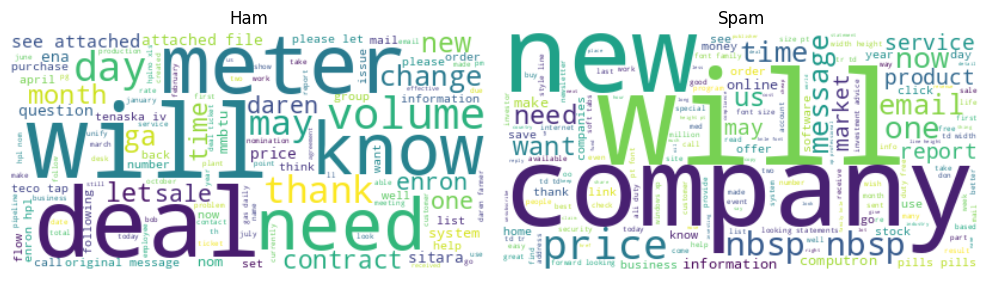

In [4]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
from sklearn.model_selection import train_test_split

# Wczytywanie danych i usuwanie nie potrzebnego tekstu
data = pd.read_csv('spam_ham_dataset.csv')
data['text']=data['text'].apply(clean_text)
 
train_data, test_data, train_class, test_class = train_test_split(data['text'], data['label_num'], random_state=123)
train_data = train_data.tolist()
test_data = test_data.tolist()
train_class = train_class.tolist()
test_class = test_class.tolist()

# Oddzielenie spam od ham
ham_train_data = [email for email, label in zip(train_data, train_class) if label == 0]
spam_train_data = [email for email, label in zip(train_data, train_class) if label == 1]

# Tworzenie chmury wyrazów
n = 10 # liczba słów
# Dla hamu
ham_wc = WordCloud(background_color="white", max_words=2000)
ham_text = ' '.join(ham_train_data)
ham_wordcloud = ham_wc.generate(ham_text)
ham_word_frequencies = ham_wc.process_text(ham_text)
ham_word_frequencies = {word: freq for word, freq in ham_word_frequencies.items() if len(word) > 1}
ham_sorted_words = sorted(ham_word_frequencies.items(), key=lambda x: x[1], reverse=True)
ham_top_words = ham_sorted_words[:n]

# Dla spamu
spam_wc = WordCloud(background_color="white", max_words=2000)
spam_text = ' '.join(spam_train_data)
spam_wordcloud = spam_wc.generate(spam_text)
spam_word_frequencies = spam_wc.process_text(spam_text)
spam_word_frequencies = {word: freq for word, freq in spam_word_frequencies.items() if len(word) > 1}
spam_sorted_words = sorted(spam_word_frequencies.items(), key=lambda x: x[1], reverse=True)
spam_top_words = spam_sorted_words[:n]

print("Ham:")
for word, frequency in ham_top_words:
    print(word, frequency)

print("\nSpam:")
for word, frequency in spam_top_words:
    print(word, frequency)

# Wyświetlanie chmury
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title("Ham")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title("Spam")
plt.axis("off")

plt.tight_layout()
plt.show()

Na obrazie widać, że najczęstszym słowem w obu kategoriach jest jest *"will"*.

Warto zauważyć, że techniki takie jak chmury wyrazów są powszechne w problemach uczenia maszynowego do eksploracji danych tekstowych przed zastosowaniem dowolnego rozwiązania. Proces ten nazywamy `analizą eksploracyjną danych` (EDA). EDA pozwala zrozumieć, w jaki sposób kierować dalszą analizą, a podstawowym narzędziem do tego zadania są metody wizualizacji.

## Statystyki



In [12]:
from scipy.stats import skew
import numpy as np
import pandas as pd

# Oblicz długość każdego e-maila.
def statystyki(maile):
    email_lengths = [len(email) for email in maile]
    return [np.mean(email_lengths),
            np.median(email_lengths),
            np.min(email_lengths),
            np.max(email_lengths),
            np.std(email_lengths),
            skew(email_lengths)]

wszystkie_wartosci=statystyki(train_data)
spam_wartosci=statystyki(spam_train_data)
ham_wartosci=statystyki(ham_train_data)

# Przykładowe dane
data = {
'':['Średnia','Mediana','Minimum','Maksimum','Odchylenie standardowe','Skośność'],
'ogólnie':wszystkie_wartosci,
'spam':spam_wartosci,
'ham':ham_wartosci,
}

display(pd.DataFrame(data).style.hide())

,ogólnie,spam,ham
Średnia,845.409747,1183.477470,702.190162
Mediana,442.000000,542.500000,405.000000
Minimum,3.000000,3.000000,22.000000
Maksimum,16143.000000,14454.000000,16143.000000
Odchylenie standardowe,1260.553117,1724.927561,965.782383
Skośność,4.422576,2.983645,5.809157


Skośność to miara asymetrii rozkładu prawdopodobieństwa. 

Wartość skośności może być dodatnia lub ujemna, lub nawet niezdefiniowana:

- Jeśli skośność jest mniejsza od zera, dane są lewostronnie skośne i większość wartości jest większa od średniej.
- Jeśli skośność jest równa zero, dane są symetryczne, chociaż niekoniecznie normalne.
- Jeśli skośność jest większa od zera, dane są prawostronnie skośne.

Wartość skośności wynosi 4.42, co jest dużo większe od zera. To sugeruje, że długości e-maili są prawostronnie skośne, co oznacza, że większość e-maili ma długość mniejszą od średniej, a długie e-maile są rzadkością. W takim przypadku, mediana będzie mniejsza od średniej.

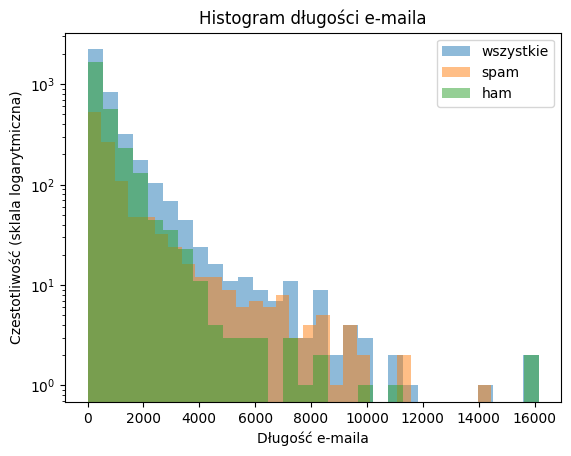

In [6]:
import matplotlib.pyplot as plt

# Narysuj histogramy dla każdej serii na tym samym wykresie.
plt.hist(eml, bins=30, alpha=0.5, label='wszystkie', log=True)
plt.hist(spl, bins=30, alpha=0.5, label='spam', log=True)
plt.hist(hml, bins=30, alpha=0.5, label='ham', log=True)

plt.title("Histogram długości e-maila")
plt.xlabel("Długość e-maila")
plt.ylabel("Czestotliwość (sklala logarytmiczna)")
plt.legend(loc='upper right')  # dodaj legende.
plt.show()

## Klasyfikacja

Terminem określającym przeciwieństwo wiadomości spamowych jest "ham" (szynka), ponieważ oba słowa są związane z produktami mięsnymi (spam odnosi się do konserwowej szynki). W tym ćwiczeniu korzystamy z podzbioru zbioru wiadomości.

Na początku czytamy wiadomości dla obu kategorii (ham i spam) i dzielimy je na grupy treningowe i testowe. Zasadniczo możemy wybrać podział 75:25 między dwoma zestawami, przypisując większą część danym treningowym.

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Załaduj dane.
data = pd.read_csv('spam_ham_dataset.csv')
data['text'] = data['text'].apply(clean_text)

# Podziel dane na zbiory treningowy i testowy.
train_data, test_data, train_class, test_class = train_test_split(data['text'], data['label_num'], random_state=123)

# Skonwertuj serię pandas na listy.
train_data = train_data.tolist()
test_data = test_data.tolist()
train_class = train_class.tolist()
test_class = test_class.tolist()

# Oddziel dane dotyczące wiadomości "ham" i "spam" dla dalszej analizy, jeśli jest to konieczne.
ham_train_data = [email for email, label in zip(train_data, train_class) if label == 0]
spam_train_data = [email for email, label in zip(train_data, train_class) if label == 1]
ham_test_data = [email for email, label in zip(test_data, test_class) if label == 0]
spam_test_data = [email for email, label in zip(test_data, test_class) if label == 1]

Następnym krokiem jest preprocessowanie danych przy użyciu poznanych wcześniej technik. W poniższym kodzie usuwamy wszystkie słowa funkcyjne.

In [7]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Tokenizuj dane treningowe/testowe.
train_data = [word_tokenize(i) for i in train_data]
test_data = [word_tokenize(i) for i in test_data]


# Metoda usuwania słów kluczowych.
def remove_stop_words(input):
    result = [i for i in input if i not in ENGLISH_STOP_WORDS]
    return result

# Usuń słowa kluczowe.
train_data = [remove_stop_words(i) for i in train_data]
test_data = [remove_stop_words(i) for i in test_data]

Teraz lematyzujemy słowa.

In [8]:
# Stwórz lematyzer.
lemmatizer = WordNetLemmatizer()

# Metoda lematyzacji tekstu.
def lemmatize_text(input):
    return [lemmatizer.lemmatize(i) for i in input]

# Lematyzuj tekst.
train_data = [lemmatize_text(i) for i in train_data]
test_data = [lemmatize_text(i) for i in test_data]

# Odtwórz dane.
train_data = [" ".join(i) for i in train_data]
test_data = [" ".join(i) for i in test_data]

Kontynuujemy ekstrakcją cech dla każdego zdania w obu zestawach. Ten krok wykorzystuje wektorizację tf-idf, po uprzednim wtrenowaniu wektoryzera na danych treningowych.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Stwórz wektorizer.
vectorizer = TfidfVectorizer()

# Dopasuj do danych treningowych.
vectorizer.fit(train_data)

# Przekształć dane testowe/treningowe na cechy.
train_data_features = vectorizer.transform(train_data)
test_data_features = vectorizer.transform(test_data)

print(train_data_features.shape)

(3878, 41576)


Każda z *3878* wiadomości email w zestawie treningowym jest reprezentowana przez wektor cech o rozmiarze *39192*.

## Maszyny wektorów nośnych(SVM)

Jednym z najbardziej znanych algorytmów uczenia maszynowego nadzorowanego jest algorytm `Support Vector Machines` – maszyny wektorów nośnych.

Oceniamy jego wydajność zarówno w zestawie testowym, jak i treningowym. Głównie interesuje nas pierwszy wynik, ponieważ on mierzy dokładność naszego modelu na nieznanych danych; mówiąc inaczej, jak dobrze generalizuje on wiedzę. Z drugiej strony, wyniki na zestawie treningowym wskazują, jak dobrze nasz model nauczył się z danych treningowych. Jak możesz zauważyć, dokładność w tym drugim przypadku nie zawsze wynosi *100%*, czego można by się spodziewać. W praktycznych zastosowaniach prawie zawsze jest znacznie niższa niż *99%*.

In [19]:
from sklearn import svm

# Stwórz klasyfikator.
svm_classifier = svm.SVC(kernel="linear", C=1.0, probability=True)

# Dopasuj klasyfikator do danych treningowych.
svm_classifier.fit(train_data_features.toarray(), train_class)

# Otrzymaj wynik klasyfikacji danych treningowych.
svm_classifier.score(train_data_features.toarray(), train_class)

0.9992264053635895

Teraz wykorzystujemy zestaw testowy.

In [12]:
# Otrzymaj wynik klasyfikacji danych testowych.
svm_classifier.score(test_data_features.toarray(), test_class)

0.9860788863109049

## Naïve Bayes

`Naïve Bayes` jest algorytmem klasyfikacji opartym na `twierdzeniu Bayes'a`.

Podobnie jak w przypadku SVM, włączenie Naive Bayes jest stosunkowo proste.

In [13]:
from sklearn import naive_bayes

# Stwórz klasyfikator.
nb_classifier = naive_bayes.MultinomialNB(alpha=1.0)

# Dopasuj klasyfikator do danych treningowych.
nb_classifier.fit(train_data_features.toarray(), train_class)

# Pobierz wynik klasyfikacji danych treningowych.
nb_classifier.score(train_data_features.toarray(), train_class)

0.9620938628158845

Następnie wykorzystujemy zestaw testowy.

In [14]:
# Pobierz wynik klasyfikacji danych testowych.
nb_classifier.score(test_data_features.toarray(), test_class)

0.9234338747099768

Wyniki sugerują, że wydajność tego klasyfikatora jest niższa. Zwróć również uwagę na wynik na faktycznym zestawie treningowym, który jest niski i bardzo bliski wydajności na zestawie testowym.

## Dokładność

Standardowym podejściem w każdym problemie uczenia maszynowego jest wykorzystanie różnych algorytmów klasyfikacji i sprawdzenie, który z nich działa najlepiej. Wcześniej zastosowaliśmy dwie metody klasyfikacji do problemu filtrowania spamu, ale nasza praca się jeszcze nie skończyła; musimy dokładniej ocenić ich wydajność.

`Dokładność` to procent prawidłowo sklasyfikowanych przykładów przez algorytm, dzielony przez całkowitą liczbę przykładów. Poniższy kod oblicza dokładność na tych samych danych; jego wartość jest identyczna z wartością z poprzedniej sekcji.

In [15]:
from sklearn import metrics
 
# Pobierz przewidywane klasy.
test_class_pred = nb_classifier.predict(test_data_features.toarray())

# Oblicz dokładność na zbiorze testowym.
metrics.accuracy_score(test_class, test_class_pred)

0.9234338747099768

## Precision i Recall

`Precyzja` mówi nam o proporcji pozytywnych identyfikacji, które w rzeczywistości są poprawne, natomiast `Odwołanie` mówi nam o proporcji faktycznych elementów pozytywnych, które zostały prawidłowo zidentyfikowane.

In [16]:
# Oblicz precyzję na zbiorze testowym.
metrics.precision_score(test_class, test_class_pred)

0.992

In [17]:
# Oblicz odzyskiwanie na zbiorze testowym.
metrics.recall_score(test_class, test_class_pred)

0.7188405797101449

## F-score

`F-score`,  jest średnią harmoniczną precyzji i odwołania. Kiedy precyzja i odwołanie osiągają idealny wynik (równy *1*), F-score staje się równe *1*.

In [18]:
# Oblicz wynik F na zbiorze testowym.
metrics.f1_score(test_class, test_class_pred)

0.8336134453781513

## ROC i AUC

Kiedy klasyfikator zwraca dla każdej predykcji pewnego rodzaju wynik ufności, możemy zastosować inną technikę oceny wydajności, nazywaną krzywą `charakterystyki operacyjnej odbiornika` (ROC). Krzywa ROC jest wykresem graficznym, który pokazuje wydajność modelu przy wszystkich progach klasyfikacji. Zacieniony obszar na tych wykresach, nazywany `polem pod krzywą ROC` (AUC), jest związany z jakością naszego modelu; im większa jego powierzchnia, tym lepiej.

Następnie obliczymy krzywe ROC dla obu klasyfikatorów.

Text(0.5, 0.98, 'Porównanie krzywych ROC')

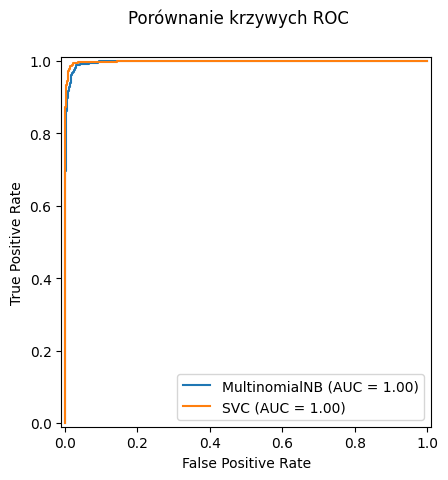

In [19]:
# Stwórz pojedynczą figurę i oś dla wykresu ROC.
fig, ax = plt.subplots()

# Uzyskaj wyniki dla każdej predykcji.
probs = nb_classifier.predict_proba(test_data_features.toarray())
test_score = probs[:, 1]

# Oblicz charakterystykę pracy odbiornika.
fpr, tpr, thresholds = metrics.roc_curve(test_class, test_score)

# Utwórz pojedynczą figurę i oś dla wykresu ROC.
roc_auc = metrics.auc(fpr, tpr)

# Stwórz krzywą ROC.
metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MultinomialNB').plot(ax=ax)

# Uzyskaj wyniki dla każdej predykcji.
probs = svm_classifier.predict_proba(test_data_features.toarray())
test_score = probs[:, 1]

# Oblicz charakterystykę pracy odbiornika.
fpr, tpr, thresholds = metrics.roc_curve(test_class, test_score)

# Oblicz pole powierzchni pod krzywą.
roc_auc = metrics.auc(fpr, tpr)

# Stwórz krzywą ROC.
svm_disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='SVC').plot(ax=ax)

svm_disp.figure_.suptitle("Porównanie krzywych ROC")

Zgodnie z rysunkiem, wartość AUC dla SVM wynosi *1*, a dla Naive Bayes *1*. Wszystkie dotychczasowe wyniki potwierdzają nasze początkowe założenie o wyższości modelu SVM.

Na koniec obliczymy krzywą ROC wraz z `krzywą Precyzj Odwołania` dla modelu Naive Bayes.

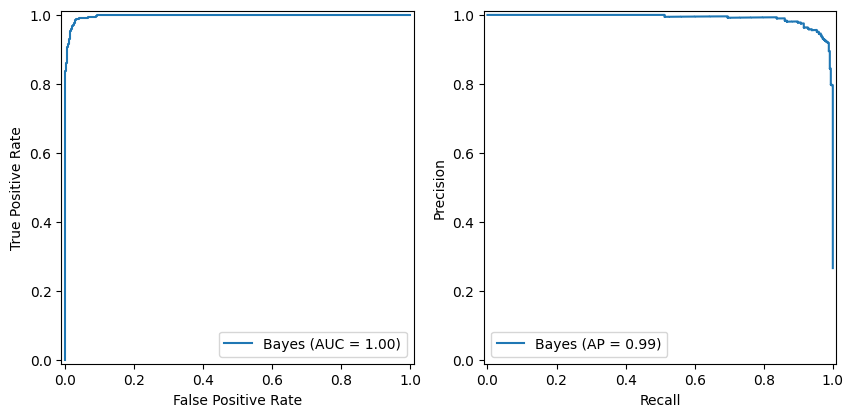

In [22]:
# Uzyskaj wyniki dla każdej predykcji.
probs = nb_classifier.predict_proba(test_data_features.toarray())
test_score = probs[:, 1]

# Oblicz charakterystykę pracy odbiornika.
fpr, tpr, thresholds = metrics.roc_curve(test_class, test_score)

# Oblicz pole powierzchni pod krzywą.
roc_auc = metrics.auc(fpr, tpr)

# Stwórz krzywą ROC.
rc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Bayes')

# Stwórz krzywe precyzja-odzyskiwanie.
precision, recall, thresholds = metrics.precision_recall_curve(test_class, test_score)
ap = metrics.average_precision_score(test_class, test_score)
pr_display = metrics.PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=ap, estimator_name='Bayes')

# Narysuj krzywe.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
rc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)

Oba wykresy podsumowują zależności między wskaźnikami na osi X i Y, wykorzystując różne progi prawdopodobieństwa. Na prawym wykresie średnia precyzja (AP) dla modelu Naive Bayes wynosi *0,99*.

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Stwórz modele.
model1 = LogisticRegression()
model2 = DecisionTreeClassifier()

# Trenuj modele.
model1.fit(train_data_features.toarray(), train_class)
model2.fit(train_data_features.toarray(), train_class)

# Uzyskaj predykcje dla każdego modelu.
pred1 = model1.predict_proba(test_data_features.toarray())
pred2 = model2.predict_proba(test_data_features.toarray())
pred3 = svm_classifier.predict_proba(test_data_features.toarray())

# Oblicz ostateczną predykcję jako średnią z predykcji trzech modeli.
final_pred = (pred1 + pred2 + pred3) / 3

# Ostateczna predykcja to klasa o najwyższym średnim prawdopodobieństwie.
final_pred = np.argmax(final_pred, axis=1)

# Oblicz dokładność hybrydowego modelu.
print("Skuteczność modelu hybrydowego: ", accuracy_score(test_class, final_pred))

Accuracy of hybrid model:  0.9783449342614076
